In [1]:
import pandas as pd
from model_fit import read_features
import joblib
import numpy as np

df = pd.read_parquet('./material/soc.topsoil_organized.pq')
mdl = joblib.load('./model/model_rf.soc_ccc_v20250301.joblib')
cov = read_features('./metric/feature_selected_soc_v20250301.txt')

mdl.n_jobs=-1
df = df.dropna(subset=cov+['soc'])
df['soc_log1p'] = np.log1p(df['soc'])
tgt = 'soc_log1p'
print(df.shape)

(100979, 614)


/opt/conda/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


## calculate standardized error for all the points

In [2]:
from sklearn.model_selection import LeavePOut, KFold
from trees_rf import cast_tree_rf
from skmap.misc import TimeTracker, ttprint

dff = df.sample(10000, random_state=42)
kf = KFold(n_splits=len(dff) // 1000)
cl = []

print(dff.shape)

ttprint('start prediction')
for i, (train_idx, test_idx) in enumerate(kf.split(dff)):
    print(f"Fold {i}:")
    # print(f"  Train: index={len(train_idx)}")
    # print(f"  Test:  index={len(test_idx)}")
    
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    mdl.fit(train[cov], train[tgt])
    qmd = cast_tree_rf(mdl)

    tree_pred = qmd.predict(test[cov])  
    tree_pred = np.expm1(tree_pred)
    
    pred = np.mean(tree_pred, axis=0)
    std = np.std(tree_pred, axis=0)

    test = test.copy()
    test["pred"] = pred
    test["std"] = std

    cl.append(test)

tested = pd.concat(cl)
ttprint('finish prediction')

(10000, 614)
[12:14:12] start prediction
Fold 0:
Fold 1:
Fold 2:
Fold 3:
Fold 4:
Fold 5:
Fold 6:
Fold 7:
Fold 8:
Fold 9:
[12:14:17] finish prediction


In [3]:
tested['std_rsd'] = (test['pred']-test['soc'])/test['std']
tested.to_parquet('./material/tdata_tested.stdz.error.pq')

## calculate semi-variance

In [4]:
dfv = pd.read_parquet('./material/tdata_tested.stdz.error.pq')

import geopandas as gpd
gdf = gpd.GeoDataFrame(dfv, geometry=gpd.points_from_xy(dfv['lon'], dfv['lat']), crs="EPSG:4326")
gdft = gdf#.iloc[0:500]
gdft = gdft.to_crs(epsg=3035)
gdft = gdft.reset_index(drop=True)

In [5]:
from scipy.spatial import distance_matrix

coords = np.array([[geom.x, geom.y] for geom in gdft.geometry])
values = gdft['std_rsd'].to_numpy()
dist_matrix = distance_matrix(coords, coords) / 1000   # pairwise distance
diff_matrix = (values[:, None] - values[None, :]) ** 2    # pairwise difference

# Extract upper triangular part (excluding diagonal)
i, j = np.triu_indices(len(gdft), k=1)
all_dists = dist_matrix[i, j]
all_diffs = diff_matrix[i, j]

sort_idx = np.argsort(all_dists)
all_dists = all_dists[sort_idx]
all_diffs = all_diffs[sort_idx]

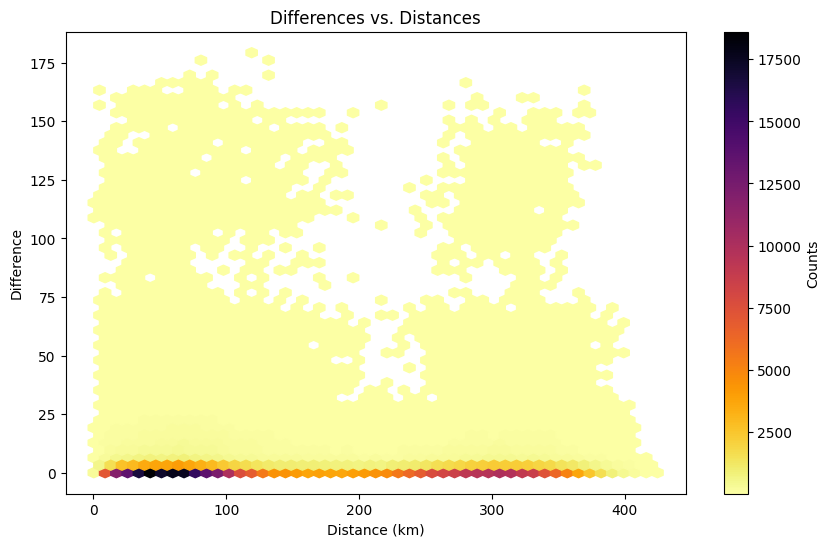

In [6]:
## visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
hb = plt.hexbin(all_dists, all_diffs, gridsize=50,cmap='inferno_r', mincnt=1)
cb = plt.colorbar(hb, label='Counts')
# plt.xlim([0,3400])
plt.xlabel('Distance (km)')
plt.ylabel('Difference')
plt.title('Differences vs. Distances')
plt.show()

## Bin the pairwise semivariance

In [7]:
from model_fit import bin_semivar
bins_size = 10
binned_dist, binned_variogram, bin_center, binned_number = bin_semivar(all_dists, all_diffs, bins_size)

/home/xuemeng/work_xuemeng/trend-with-uncertainty/model_fit.py:771: RuntimeWarning: Mean of empty slice
  binned_variograms[i - 1] = np.nanmean(all_diffs[mask])  # Average semi-variance for this bin


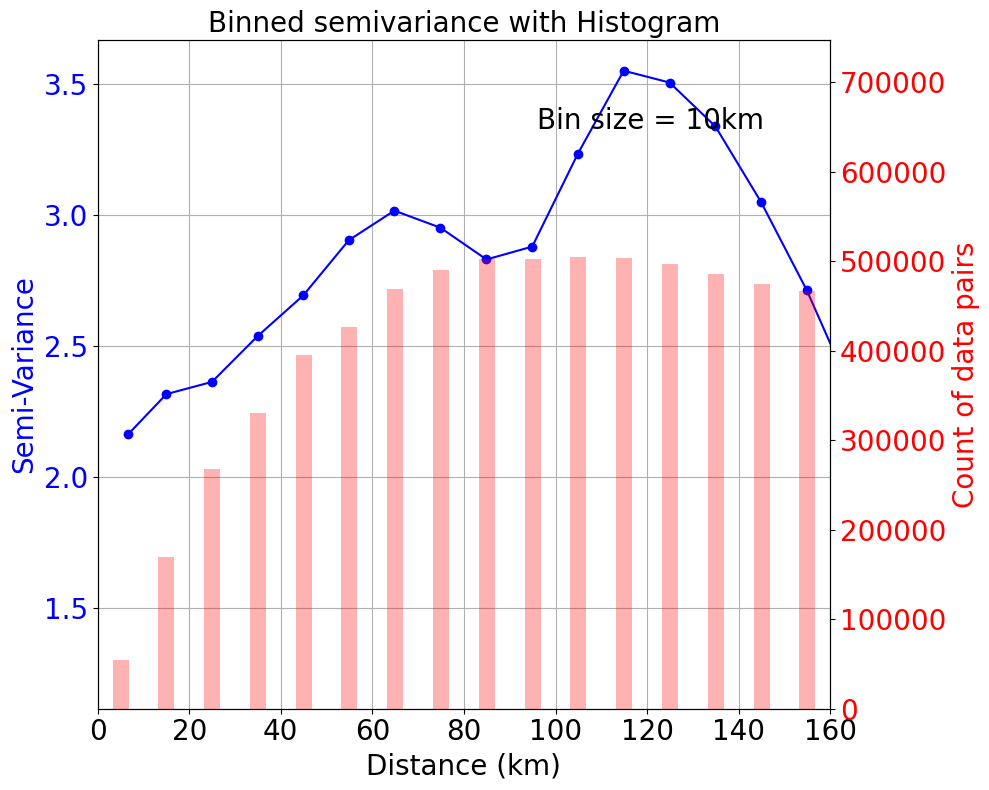

In [11]:
# visualize

fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(binned_dist, binned_variogram, marker='o', linestyle='-', color='b', label='Variogram')
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.6, 0.9, f'Bin size = {bins_size}km', 
            ha='left', va='top', transform=ax1.transAxes, fontsize=20)  

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(bin_center, binned_number, width=3.5, alpha=0.3, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

plt.title('Binned semivariance with Histogram', fontsize=20)
ax1.grid(True)
ax1.set_xlim([0,160])
# ax1.set_ylim([0,1])
fig.tight_layout()  

plt.show()

## calculate theoretical variogram

In [13]:
from model_fit import spherical_model, exponential_model, gaussian_model, fit_variogram_model

mask_tc = binned_dist <= 150 # truncated distance in km
filtered_distances = binned_dist[mask_tc]
filtered_variograms = binned_variogram[mask_tc]

# fit the theoretical variogram
# y = correlation_function(distance, *params_exponential)
params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)
print('model  nugget,   sill,   range')
print('exponential', params_exponential)
print('spherical', params_spherical)
print('gaussian', params_gaussian)


# illustrate the theoretical one
h_vals = np.linspace(0, 150, 300)
fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)
fitted_variogram_exponential = exponential_model(h_vals, *params_exponential)
fitted_variogram_gaussian = gaussian_model(h_vals, *params_gaussian)

model  nugget,   sill,   range
exponential [ 2.01065003  3.60144005 79.18892382]
spherical [-1.89049585e+03  2.88991528e+00 -5.47995172e+03]
gaussian [  2.24893069   3.30730764 -66.78731351]


/opt/conda/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


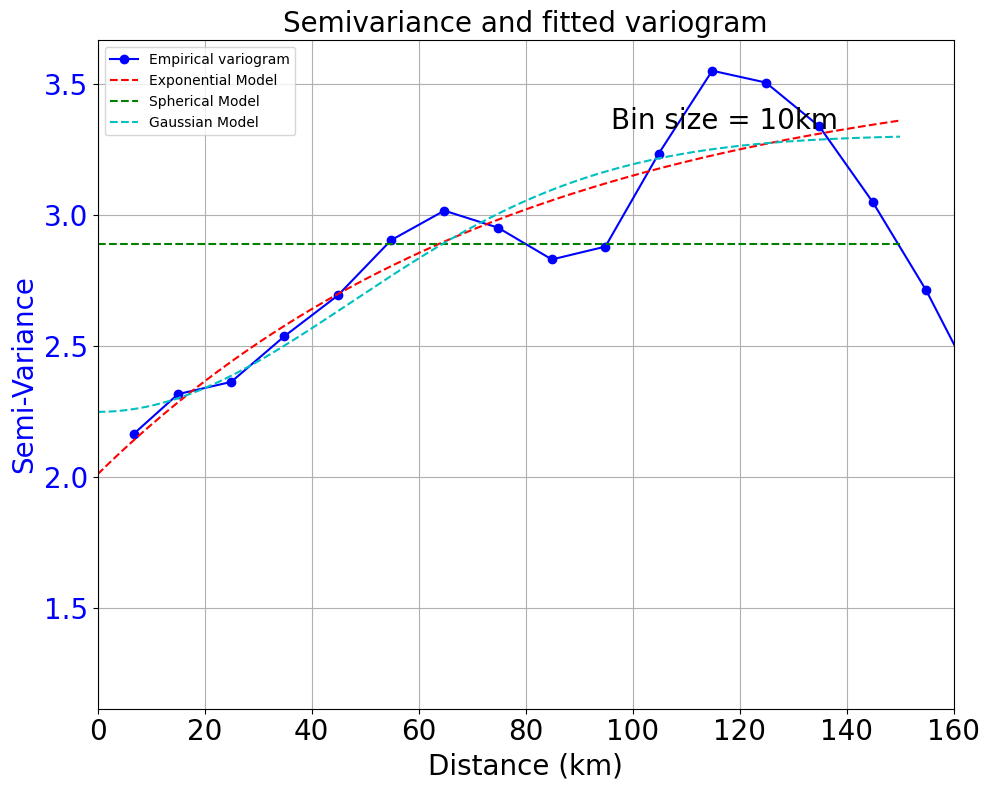

In [15]:
# visualize
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(binned_dist, binned_variogram, marker='o', linestyle='-', color='b', label='Empirical variogram')
ax1.set_xlabel('Distance (km)', fontsize=20)
# ax1.set_xlim([0, 200])
ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.6, 0.9, f'Bin size = {bins_size}km', 
            ha='left', va='top', transform=ax1.transAxes, fontsize=20)  


ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
ax1.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical Model')
ax1.plot(h_vals, fitted_variogram_gaussian, linestyle='--', color='c', label='Gaussian Model')
plt.title('Semivariance and fitted variogram', fontsize=20)
ax1.grid(True)
ax1.set_xlim([0,160])
# ax1.set_ylim([0,1])
fig.tight_layout()  
plt.legend()

plt.show()

## get the final variogram and corresponding correlation function

In [16]:
# (sill - gamma_h) / sill
correlation_values = (params_exponential[1]-exponential_model(h_vals, *params_exponential))/params_exponential[1]


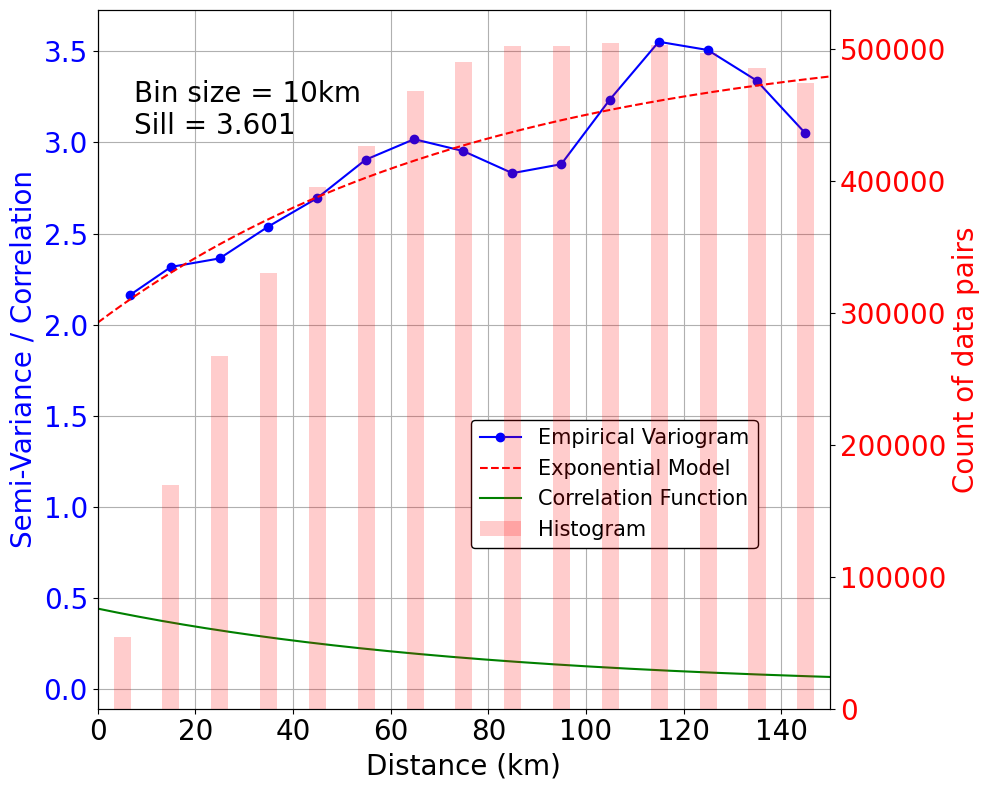

In [26]:
fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical Variogram')
ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
ax1.plot(h_vals, correlation_values, linestyle='-', color='green', label='Correlation Function')
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance / Correlation', color='b', fontsize=20)  # Shared y-axis label
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.05, 0.9, f'Bin size = {bins_size}km\nSill = {params_exponential[1]:.3f}', 
         ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position
ax1.grid(True)
ax1.set_xlim([0, 150])

ax2 = ax1.twinx()
ax2.bar(bin_center[mask_tc], binned_number[mask_tc], width=3.5, alpha=0.2, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=(0.51,0.23), fontsize=15, facecolor='white', edgecolor='black', framealpha=1)

fig.tight_layout()
# plt.savefig("/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/spatial_aggregation/plot_variogram_corrected.pdf", format='pdf',dpi=300)
plt.show()


## log

In [ ]:
# from joblib import Parallel, delayed
# from sklearn.model_selection import LeavePOut
# from trees_rf import cast_tree_rf
# import os
# from tqdm import tqdm
# from skmap.misc import TimeTracker, ttprint

# dff = df.sample(10000)

# def process_split(train_idx, test_idx):
#     train = dff.iloc[train_idx]
#     test = dff.iloc[test_idx]

#     mdl.fit(train[cov], train[tgt])
#     qmd = cast_tree_rf(mdl)

#     tree_pred = qmd.predict(test[cov])  
#     tree_pred = np.expm1(tree_pred)

#     pred = np.mean(tree_pred, axis=0)
#     std = np.std(tree_pred, axis=0)

#     test = test.copy()
#     test["pred"] = pred
#     test["std"] = std

#     return test

# lpo = LeavePOut(100)
# num_splits = sum(1 for _ in lpo.split(dff))  # Total iterations
# cl = []
# ttprint('start predicting')

# with tqdm(total=num_splits, desc="Processing splits", unit="split") as pbar:
#     results = Parallel(n_jobs=min(4, os.cpu_count() // 2))(
#         delayed(process_split)(train_idx, test_idx) for train_idx, test_idx in lpo.split(dff)
#     )
#     cl.extend(results)  # Collect results
#     pbar.update(len(results))  # Update progress bar manually
    
# ttprint('finish predicting')